# Monte Carlo Simulations: Optimal Commute to School

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Suppose you have two possible routes you could take to school:
1. highway with no traffic lights, but there is a congested region and risk of delays due to accidents or construction
2. take the residential roads, but travel times can be high if you get stuck at the lights

Some assumptions:

Assume that you always leave your house between 8:15-8:35am.

The congestion along route 1 peaks at 8:40am.

The traffic lights cycle through green/red for some length of time between 1-2 minutes *each*, and are 2 minutes apart.

**You need to be at school by 9am!**

## Parameters

In [2]:
num_trials = 100   # number of simulated trials, per departure time
depart_min = 15    # representing 8:15
depart_max = 35    # representing 8:30

# Route 1 parameters
base_route1 = 18   # base minutes for route 1
merge_offset = 10  # minutes into route 1 when you reach the merge
peak_time = 40     # congestion peak at 8:40
peak_spread = 5    # width of congestion peak, peak_time +/- peak_spread minutes

accident_base = 0.01  # base probability of a highway accident
accident_peak = 0.05  # higher risk of accidents near peak time

# Route 2 parameters
base_route2 = 24            # base minutes for route 2
num_lights = 5              # number of traffic lights along route 2
green_min, green_max = 1,2  # min and max length of a green light
red_min, red_max = 1,2      # min and max length of a red light
light_offset = 10           # minutes into Route 2 when you encounter first light

### Warmup Questions 🧠
Discuss with your small group:
1. What do the different parameters mean/represent?
2. Do you think the results from your simulation will be sensitive to any of these parameters?

----

## Part 1: Simulating Delays for Route 1
Code has been provided below that models the various delays along Route 1 as functions of `arrival_time`

In [3]:
def merge_delay(arrival_time):
    """
    Delay increases near 8:40 using a Gaussian bump.
    """
    max_merge_delay = 10
    bump = max_merge_delay * np.exp(-((arrival_time - peak_time) ** 2) / (2 * peak_spread ** 2))
    variability = 3 + 1.5 * np.random.randn() # add some variability/noise
    return max(0, bump + variability)


def accident_delay(arrival_time):
    """
    Probability of accident also peaks around 8:40.
    Accident delays are heavy-tailed.
    """
    prob = accident_base + (accident_peak - accident_base) * \
           np.exp(-((arrival_time - peak_time) ** 2) / (2 * peak_spread ** 2))
    if np.random.rand() < prob:
        min_accident = 10
        max_accident = 15
        return np.random.uniform(min_accident,max_accident)
    return 0


Let's make sure we've modeled these correctly. 

### Q: Please plot each of these delays vs. `arrival_time`

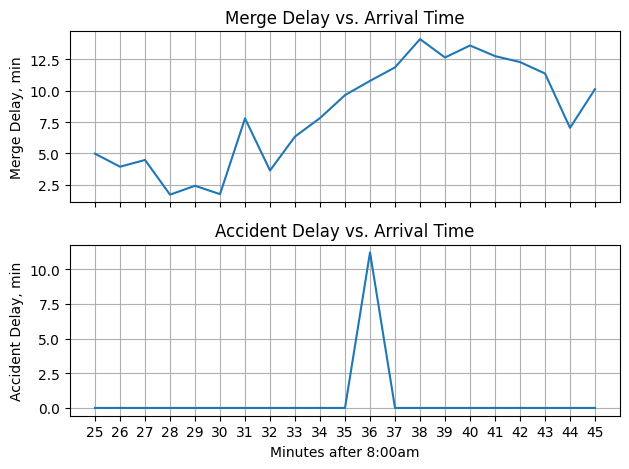

In [4]:
# Fill in the plotting code!
arrivals = range(  depart_min +merge_offset ,  depart_max +merge_offset+1)      # arrival at the merge
merge_delays = [merge_delay(arrival) for arrival in arrivals ]
accident_delays = [accident_delay(arrival) for arrival in arrivals]

fig, axes = plt.subplots(2,1, tight_layout=True, sharex=True)
axes[0].plot(arrivals, merge_delays)
axes[1].plot(arrivals, accident_delays)

axes[0].set_title("Merge Delay vs. Arrival Time")
axes[0].set_ylabel("Merge Delay, min")

axes[1].set_title("Accident Delay vs. Arrival Time")
axes[1].set_xticks([int(a) for a in arrivals ])
axes[1].set_xlabel("Minutes after 8:00am")
axes[1].set_ylabel("Accident Delay, min")

axes[0].grid()
axes[1].grid()
plt.show()

### Q: What do you notice about these plots? How do we interpret these physically?

### A:
Increasing and then decresasing with increased arrival time. Larger spread with merge delay. Spike of accidents makes sense because more cars on the road means increased freq of collisions.

----

## Part 2: Simulating Delays For Route 2

Next, we will do a similar process for delays along route 2!

In [ ]:
def red_light_bias(arrival_time):
    """
    Returns a multiplier for red-light probability based on how close
    the arrival time is to the peak (8:40 = minute 40).

    The multiplier is max_bias near peak, and 0 far away.
    """
    max_bias = 2
    return max_bias*np.exp(-((arrival_time - peak_time)**2) / (2 * peak_spread**2))


def traffic_light_delay_with_peak_bias(depart_time, n):
    """
    Traffic light model:
      - Normally, arrival phase is uniform across green+red cycle.
      - Peak times: near 8:40, you're more likely to land in the red portion
        of the cycle (queues, slowdowns, heavier volumes).
    """
    total = 0
    for i in range(n):
        # Each light is assumed to be 2 minutes apart on average
        arrival_at_light = depart_time + light_offset + 2*i

        # Light cycle
        g = np.random.uniform(green_min, green_max)
        r = np.random.uniform(red_min, red_max)
        cycle = g + r

        # Normally: phase = Uniform(0, cycle)
        phase = np.random.uniform(0, cycle)

        # Compute biased chance of being in red
        red_multiplier = red_light_bias(arrival_at_light)
        effective_red_length = min(r * red_multiplier, cycle)

        if phase > g and (phase - g) < effective_red_length:
            # Delay = remaining time in the (possibly lengthened) red region
            delay = effective_red_length - (phase - g)
            total += delay

    return total

Again, we need to check that we understand our code.

### Q: Please plot the red light bias and traffic light delays vs. the appropriate time variable

Read the function definitions carefully!

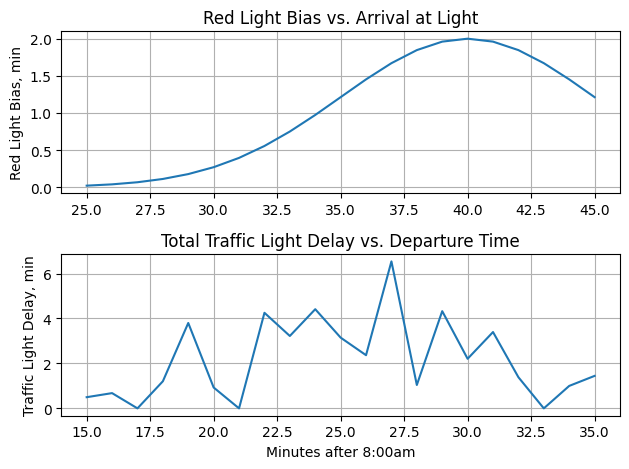

In [8]:
# Fill in the plotting code!
departs = range( depart_min , depart_max+1)
red_biases = [red_light_bias(d+light_offset)for d in departs]
light_delays =  [traffic_light_delay_with_peak_bias(d, num_lights) for d in departs]

fig, axes = plt.subplots(2,1, tight_layout=True)
axes[0].plot([d+light_offset for d in departs], red_biases)
axes[1].plot(departs, light_delays)

axes[0].set_title("Red Light Bias vs. Arrival at Light")
axes[0].set_ylabel("Red Light Bias, min")

axes[1].set_title("Total Traffic Light Delay vs. Departure Time")
axes[1].set_xlabel("Minutes after 8:00am")
axes[1].set_ylabel("Traffic Light Delay, min")

axes[0].grid()
axes[1].grid()
plt.show()

### Q: What do you notice about these plots? How do we interpret these physically?

### A:
Total traffic light delay fluctuates between increasing and decreasing with minutes after 8am, it looks much more random and jagged. There's more noise. Red light bias on the other hand is much more smooth, with a wider base and a longer delay before increasing.

----

## Part 3: Simulating the Two Commute Options

No we're ready to put all of this together! 

### Q: Please fill in the code so that it runs `num_trials` simulations for each departure time

In [9]:
records = []

for depart in range(  depart_min  ,  depart_max+1  ):
    for _ in range(  0, num_trials+1 ):
        
        # ---------- Route 1 ----------
        arrival_at_merge = depart + merge_offset
        r1 = (base_route1 +
              merge_delay(arrival_at_merge) +
              accident_delay(arrival_at_merge))

        # ---------- Route 2 ----------
        r2 = base_route2 + traffic_light_delay_with_peak_bias(depart, num_lights)

        records.append([depart, r1, r2])

df = pd.DataFrame(records, columns=["depart_min", "route1_time", "route2_time"])

----

## Part 4: Visualizing and Interpreting Results

Great! We ran a bunch of Monte Carlo simulations for each route and each departure time.

But what did we actually care about? Why did we do this in the first place?

We want to check that:
1. We will it to school by 9am
2. Determine if one of the routes is better than the other (either in transit time or arrival time)

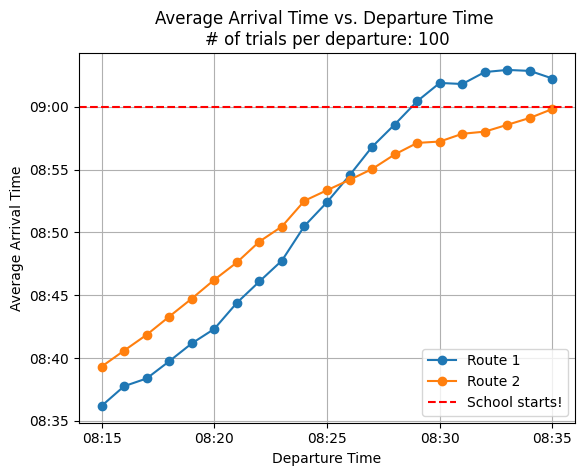

In [11]:
route_avg_by_depart = df.groupby(by="depart_min").mean()
depart_vals = route_avg_by_depart.index.values

# Convert minutes after 8:00 into timestamps
depart_times = pd.to_datetime("08:00", format="%H:%M") + pd.to_timedelta(depart_vals, unit="m")
arrival1 = pd.to_datetime("08:00", format="%H:%M") + pd.to_timedelta(depart_vals + route_avg_by_depart.route1_time.values, unit="m")
arrival2 = pd.to_datetime("08:00", format="%H:%M") + pd.to_timedelta(depart_vals + route_avg_by_depart.route2_time.values, unit="m")

# plot results
ax = plt.subplot(1,1,1)
plt.plot(depart_times, arrival1, "-o", label="Route 1")
plt.plot(depart_times, arrival2, "-o", label="Route 2")
ax.axhline(pd.to_datetime("09:00", format="%H:%M"), color="red", linestyle="--", label="School starts!")

# format axes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Departure Time")
plt.ylabel("Average Arrival Time")
plt.title(f"Average Arrival Time vs. Departure Time \n# of trials per departure: {num_trials}")

plt.grid()
plt.legend()
plt.show()

### Q: Do you always make it to school by 9am?

### A:
No, clearly after around 8.27 both lines are above the red dashed line.

### Q: Which route is better, on average?

### A:
YOUR ANSWER HERE

### Q: What else might be useful to know other than average arrival time?

### A:
YOUR ANSWER HERE

### Key Takeaways 🔑

Monte Carlo simulations can help us understand more complex relationships and outcomes! In this example, we broke up a complicated scenario into smaller ones. Remember to sanity check your simulations as you develop them as well as the results!